#### Import as usual

In [1]:
import os
import datetime
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import miditok as midi
from functions import get_tokens, split_input_target, positional_encoding, masked_loss, masked_accuracy

In [8]:
%load_ext tensorboard

#### Get the tokens and some information about our data and some basic prep

In [55]:
path = 'Final_Project/combined_BPE/'
def get_tokens(path): # function to get all tokens from the dataset and put them in a numpy array
    to_shuffle = np.array(()) # to_shuffle aggregator for one piece
    data = np.array(()) # data aggregator for one piece
    piece_counter = 0
    
    for filename in os.listdir(path):
        if filename.endswith('.npy'):
            to_shuffle = np.append(to_shuffle, np.load(path + filename, allow_pickle=True)[()])
    np.random.shuffle(to_shuffle)
    print(to_shuffle)
    
    for i in range(len(to_shuffle)):
        data = np.append(data, 1)
        for j in range(len(to_shuffle[i].get('tokens'))):
            data = np.append(data, to_shuffle[i].get('tokens')[j])
        data = np.append(data, 2)
        piece_counter += 1
        
    return data, piece_counter

data, piece_counter = get_tokens(path)

[{'tokens': [[3, 204, 14, 267, 26, 252, 38, 246, 3, 214, 14, 101, 135, 26, 97, 187, 38, 102, 187, 3, 204, 24, 102, 153, 36, 105, 162, 3, 200, 34, 103, 135, 201, 22, 104, 133, 211, 20, 267, 212, 33, 104, 141, 213, 21, 101, 140, 3, 198, 19, 425, 31, 103, 133, 217, 17, 425, 29, 340, 3, 205, 15, 99, 132, 27, 101, 134, 3, 213, 38, 250, 214, 14, 253, 26, 246, 3, 244, 38, 283, 190, 14, 252, 26, 267, 322, 38, 102, 187, 194, 14, 100, 135, 26, 99, 187, 215, 37, 106, 160, 216, 25, 101, 154, 3, 214, 22, 99, 134, 34, 104, 133, 279, 21, 100, 143, 33, 103, 142, 209, 32, 102, 134, 210, 20, 100, 133, 3, 196, 17, 99, 131, 29, 101, 133, 217, 16, 100, 132, 28, 100, 134, 475, 199, 14, 252, 26, 351, 38, 252, 3, 208, 14, 267, 26, 292, 38, 282, 3, 209, 14, 229, 26, 240, 210, 38, 249, 50, 249, 254, 26, 225, 38, 232, 50, 249, 62, 269, 194, 74, 118, 129, 195, 38, 114, 130, 50, 116, 129, 62, 118, 129, 196, 68, 282, 208, 29, 116, 130, 41, 116, 130, 53, 118, 130, 63, 224, 65, 116, 130, 219, 30, 232, 42, 227, 54, 26

smallest token:3.0, biggest token:511.0, number of unique tokens:(508,), missing tokens:{0, 1, 2, 188}
number of tokens: 18392351
number of pieces: 1355
average tokens per piece: 13573.690774907749


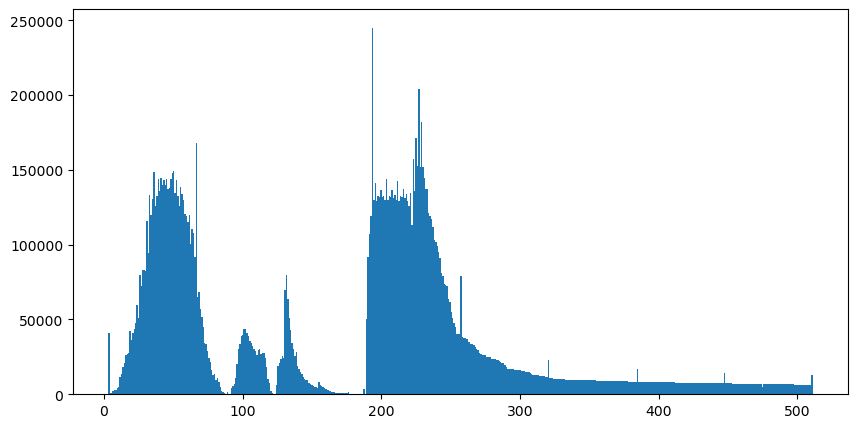

In [8]:
path = 'Final_Project/combined_BPE/'
tokens, piece_counter = get_tokens(path) # get all tokens from the dataset
unique_tokens, count = np.unique(tokens, return_counts=True)
vocab_size = int(np.max(tokens)) + 1 # get the size of the vocabulary

print("smallest token:{}, biggest token:{}, number of unique tokens:{}, missing tokens:{}".format(np.min(tokens),np.max(tokens),np.unique(tokens).shape,set(range(0, 500))-set(tokens))) # print some information about the tokens
print("number of tokens: {}".format(len(tokens))) # print the number of tokens
print("number of pieces: {}".format(piece_counter)) # print the number of pieces
print("average tokens per piece: {}".format(len(tokens)/piece_counter)) # print average tokens per piece

# plot the distribution of the tokens
plt.figure(figsize=(10, 5))
plt.hist(tokens, bins=500)
plt.show()


data = tf.cast(tokens, tf.int32) # put tokens into a tensor and cast to int32
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n] # first 90% of data
val_data = data[n:] # last 10% of data

In [9]:
print(dict(zip(unique_tokens, count))) # print the distribution of the tokens

{3.0: 40916, 4.0: 292, 5.0: 750, 6.0: 581, 7.0: 1976, 8.0: 3124, 9.0: 3158, 10.0: 4164, 11.0: 4989, 12.0: 11243, 13.0: 13235, 14.0: 18427, 15.0: 20947, 16.0: 26500, 17.0: 27095, 18.0: 27676, 19.0: 42287, 20.0: 36350, 21.0: 41299, 22.0: 43762, 23.0: 47404, 24.0: 59426, 25.0: 50787, 26.0: 80017, 27.0: 72369, 28.0: 83141, 29.0: 83246, 30.0: 82179, 31.0: 115658, 32.0: 94607, 33.0: 133224, 34.0: 120054, 35.0: 130833, 36.0: 148677, 37.0: 125563, 38.0: 132641, 39.0: 143950, 40.0: 135750, 41.0: 144352, 42.0: 140183, 43.0: 143155, 44.0: 140177, 45.0: 144238, 46.0: 137288, 47.0: 137980, 48.0: 144017, 49.0: 148228, 50.0: 149253, 51.0: 134727, 52.0: 143413, 53.0: 132246, 54.0: 125995, 55.0: 138564, 56.0: 134026, 57.0: 129691, 58.0: 120818, 59.0: 119507, 60.0: 115179, 61.0: 119656, 62.0: 100326, 63.0: 110684, 64.0: 107580, 65.0: 92031, 66.0: 82973, 67.0: 84757, 68.0: 65366, 69.0: 68172, 70.0: 56860, 71.0: 51614, 72.0: 45004, 73.0: 34219, 74.0: 33790, 75.0: 29027, 76.0: 24502, 77.0: 21279, 78.0: 160

#### Transformer via subclassing

In [3]:
# layer for embedding and positional encoding
class PostionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, block_size, dropout_rate):
        super(PostionalEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.block_size = block_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
                          output_dim=d_model, # each token gets a 512-vector embedding
                          input_length=block_size)
        self.pos_encoding = positional_encoding(block_size, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    @tf.function
    def call(self, x):
        x = self.embedding(x) + self.pos_encoding[:, :self.block_size, :]
        x = self.dropout(x)
        return x
    
# dot-product attention
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(ScaledDotProductAttention, self).__init__()
        self.head_size = d_model // n_heads
        self.key = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.query = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.value = tf.keras.layers.Dense(units=self.head_size, use_bias=False)

    @tf.function
    def call(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute scores
        scores = tf.matmul(q,tf.transpose(k, perm=[0, 2, 1])) / tf.math.sqrt(tf.cast(self.head_size, tf.float32))
        tril = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
        scores = tf.where(tril == 0, tf.fill(tril.shape, -float('inf')), scores)
        scores = tf.nn.softmax(scores, axis=-1)
        # weighted sum of values
        v = self.value(x)
        return tf.matmul(scores, v)

# multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads,):
        super(MultiHeadAttention, self).__init__()
        self.heads = [ScaledDotProductAttention(d_model, n_heads) for _ in range(n_heads)]
        self.dense = tf.keras.layers.Dense(units=d_model, use_bias=False)
    
    @tf.function
    def call(self, x):
        x = tf.concat([head(x) for head in self.heads], axis=-1)
        x = self.dense(x)
        return x
    
# feed-forward network
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=dff, activation=tf.nn.gelu)
        self.dense2 = tf.keras.layers.Dense(units=d_model)

    @tf.function
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# implementaion of SwiGLUFFN
class SwiGLUFFN(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(SwiGLUFFN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=(dff//3)*2, activation=tf.nn.silu, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(units=(dff//3)*2, use_bias=False)
        self.dense3 = tf.keras.layers.Dense(units=d_model, use_bias=False)

    @tf.function
    def call(self, x):
        w = self.dense1(x)
        v = self.dense2(x)
        x = self.dense3(w*v)
        return x

# decoder layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = SwiGLUFFN(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.add = tf.keras.layers.Add()
    
    @tf.function
    def call(self, x):
        res_x = x
        x = self.layernorm(x)
        x = self.mha(x)
        x = self.dropout(x)
        x = self.add([res_x, x])
        res_x = x
        x = self.layernorm(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = self.add([res_x, x])
        return x
    
# decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Decoder, self).__init__()
        self.embedding = PostionalEmbedding(vocab_size, d_model, block_size, dropout_rate)
        self.layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]

    
    @tf.function
    def call(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x
    
# transformer
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Transformer, self).__init__()
        self.decoder = Decoder(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size)
        self.final_dense = tf.keras.layers.Dense(units=vocab_size)
    
    @tf.function
    def call(self, x):
        x = self.decoder(x)
        logits = self.final_dense(x)
            
        try:      
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        return logits
    
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### Hyperparams

In [4]:
d_model = 192 # also embedding size
dff = 768 # inner feedforward layer dim
n_heads = 8 # number of heads in the multihead attention layer
d_v, d_q, d_k = d_model // n_heads , d_model // n_heads , d_model // n_heads # dimension of the query, key and value vectors 
n_layers = 6 # number of layers
dropout_rate = 0.1 # dropout rate
epochs = 100
seq_length = 4096 # length of the sequence
batch_size = 8 # batch size

In [5]:
# create the model with the specified parameters 
model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

model.build(input_shape=(None, seq_length))

# model.load_weights('dmodel 128 dff 512 nheads 8 nlayers 6 dropout 0.1 epochs 100 seqlen 512 batch 64.h5')



In [6]:
def make_batches(ds):
    return ds.shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
# create tf.data.Dataset objects for training and validation
train_ds, val_ds = tf.data.Dataset.from_tensor_slices(train_data), tf.data.Dataset.from_tensor_slices(val_data)
# generate sequences of length with .batch and then split the sequences into input and target
train_ds, val_ds = train_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target), val_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target) 
# shuffle, batch and prefetch as usual
train_ds, val_ds = make_batches(train_ds), make_batches(val_ds)

# set the learning rate to our creeted custom schedule
learning_rate = CustomSchedule(d_model)

# create the optimizer with the learning rate and the other parameters as specified in the paper
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# create the model with the specified parameters 
model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

model.build(input_shape=(None, seq_length))

model.load_weights('models/dmodel 192 dff 768 nheads 8 nlayers 6 dropout 0.1 epochs 100 seqlen 4096 batch 8.h5')

In [ ]:
# save weights of the model after every epoch
checkpoint_path = "checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model,
                            optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=None)

# compile the model with the masked loss and masked accuracy
model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

# train the model 
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# save the model
model.save_weights('dmodel:{} dff:{} nheads:{} nlayers:{} dropout:{} epochs:{} seqlen:{} batch:{}.h5'.format(d_model, dff, n_heads, n_layers, dropout_rate, epochs, seq_length, batch_size))

In [ ]:
max_len = 512
start_token = tf.constant([[89] + [3] + [0] * (seq_length)], dtype=tf.int64)
np.delete(start_token, 0, 1)

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
max_len = 100
start_token = tf.constant([[89] + [0] * (seq_length - 1)], dtype=tf.int64)

def generate_tokens_greedy(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        probs = tf.nn.softmax(logits, axis = -1) # get the probabilities 
        argmax = tf.argmax(probs, axis = -1) # get the token with the highest probability
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = argmax[:,i].numpy() # add the predicted token to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if argmax[:,i].numpy() == 176: # stop when the end token is predicted
            break
    return start_token

def generate_tokens_sampling(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = tf.random.categorical(logits[:,i], num_samples=1).numpy() # sample a token from the logits and add it to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if start_token_numpy[:, i+1] == 2: # stop when the end token is predicted
            break
    return start_token

sample_song = generate_tokens_sampling(model, start_token, max_len)
sample_song.numpy().shape

(1, 4096)

In [19]:
np.save('sample_song.npy',sample_song.numpy())

In [14]:
from miditok import REMI, MIDITokenizer
tokenizer = REMI()
tokenizer.load_params('Final_Project/tokens_BPE/config.txt')
coverted = tokenizer(sample_song, [(0, False)])
coverted.dump('sample_song_sampling.mid')

AttributeError: can't set attribute 'vocab'

In [113]:
from miditok import REMI, MIDITokenizer
from miditok.utils import get_midi_programs
from miditoolkit import MidiFile
from pathlib import Path
tokenizer = REMI()
cock = MidiFile('Final_Project/Dataset/chopin/chp_op18.mid')
schwanz = tokenizer(MidiFile('Final_Project/Dataset/chopin/chp_op31.mid'))
tokens = tokenizer(cock) 
coverted_back = tokenizer(tokens, [(0, False), (0, False)])

In [115]:
len(tokens)

2

In [66]:
def json_rdy(sample):
    sample = sample.numpy().tolist()[0]
    sample = {"tokens" : [sample,sample], "programs" : [[0, False],[0, False]]}
    with open('{}.json', 'w'.format(sample)) as fp:
        json.dump(json_rdy(sample), fp)    
    return sample

None


In [45]:
sample_song.numpy()

# covert numpy array to list
list = sample_song.numpy().tolist()[0]
[list]

fil = {"tokens" : [list,list], "programs" : [[0, False],[0, False]]}
fil

{'tokens': [[89,
   218,
   16,
   96,
   153,
   28,
   97,
   153,
   194,
   28,
   96,
   252,
   32,
   97,
   248,
   21,
   94,
   157,
   28,
   96,
   157,
   33,
   97,
   153,
   1,
   192,
   28,
   96,
   139,
   193,
   28,
   96,
   138,
   35,
   96,
   138,
   36,
   97,
   138,
   194,
   16,
   258,
   28,
   231,
   198,
   28,
   456,
   40,
   260,
   218,
   16,
   258,
   28,
   231,
   190,
   28,
   260,
   36,
   456,
   16,
   258,
   28,
   231,
   206,
   28,
   260,
   36,
   492,
   20,
   297,
   32,
   231,
   214,
   28,
   260,
   36,
   429,
   20,
   258,
   32,
   227,
   190,
   32,
   260,
   39,
   456,
   20,
   258,
   32,
   231,
   206,
   32,
   293,
   38,
   492,
   20,
   258,
   32,
   231,
   214,
   28,
   260,
   34,
   429,
   20,
   94,
   169,
   28,
   95,
   169,
   33,
   95,
   169,
   208,
   32,
   93,
   127,
   38,
   291,
   44,
   264,
   210,
   20,
   258,
   32,
   231,
   214,
   32,
   293,
   38,
   260,
   44,
  